This is the notebook that I used on google colab to convert grib files to netcedf and regrid them to coarser resolution.

In [ ]:
!sudo apt-get install cdo

In [ ]:
# !pip install xarray[complete]
# !pip install cfgrib
# !pip install eccodes

In [ ]:
import xarray as xr
import glob
import os
import subprocess
import datetime
import pandas as pd

In [ ]:
if not os.path.exists('./RAW'):
  os.makedirs('./RAW')
if not os.path.exists('./Netcdf'):
  os.makedirs('./Netcdf')
if not os.path.exists('./PROCCED'):
  os.makedirs('./PROCCED')

In [ ]:
def extract_save_nc(filename_nc):
  top = 43
  bottom = 32
  left = 360 - 125
  right = 360 - 113
  ds = xr.open_dataset(filename_nc)
  ds = ds.rename({'param37.6.209':'pr'})
  ds = ds.sel(alt=ds.alt[0]).drop('alt')
  ds_sel = ds.isel(lon=(ds.lon >= left) & (ds.lon <= right),
                  lat=(ds.lat >= bottom) & (ds.lat <= top))
  ds_sel = ds_sel.assign_coords(lon = ds_sel.lon-360)
  yr = int(filename_nc[46:50])
  mon = int(filename_nc[50:52])
  day = int(filename_nc[52:54])
  hr = int(filename_nc[55:57])
  target_datetime = pd.to_datetime(datetime.datetime(yr, mon, day, hr))
  ds_sel = ds_sel.mean('time').assign_coords(time = target_datetime).expand_dims('time')
  newlon = ds_sel.lon[2:2000:5].values
  newlat = ds_sel.lat[2:2000:5].values
  ds_sel_interp = ds_sel.interp(lat = newlat, lon = newlon)

  return ds_sel_interp

In [ ]:
def grib2nc(files):
  for filename_grib in files:
    filename_nc = './Netcdf/'+filename_grib.split('/')[-1][:-6]+'.nc'
    filename_PROCCED = './PROCCED/'+filename_grib.split('/')[-1][:-6]+'.nc'
    if not os.path.exists(filename_PROCCED):
      bash_command = f'cdo -f nc copy {filename_grib} {filename_nc}'
      process = subprocess.Popen(bash_command.split(), stdout=subprocess.PIPE)
      output, error = process.communicate()

      ds_sel = extract_save_nc(filename_nc)
      ds_sel.to_netcdf(filename_PROCCED)

Copy all the .grib files to RAW directory and let the following line run. You probably need to copy files in 5 day chunks, cause otherwise colab will crash when uploading large number of files.

In [ ]:
files = glob.glob('./RAW/*.grib2')
files.sort()

In [ ]:
grib2nc(files)
for file in files:
  os.remove(file)

## Sample plot to check data validity:

In [ ]:
files = glob.glob('./drive/MyDrive/CAflood_2023/PROCCED/*.nc')
files.sort()

In [ ]:
ds = xr.open_mfdataset(files, concat_dim='time', combine='nested')

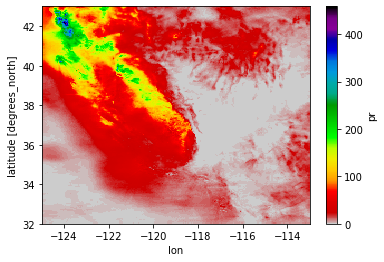

In [ ]:
ds.sum('time').pr.plot(cmap='nipy_spectral_r')

## CA land mask:

In [ ]:
!pip install git+https://github.com/regionmask/regionmask

In [ ]:
!pip install cartopy
import cartopy

In [3]:
import regionmask
import xarray as xr

In [4]:
ds = xr.open_dataset('./MRMS_MultiSensor_QPE_01H_Pass2_00.00_20221223-000000.nc')

In [17]:
states = regionmask.defined_regions.natural_earth_v5_0_0.us_states_50
mask = states.mask(ds.lon.values, ds.lat.values)
mask = (mask.where(mask==4)>0)

In [20]:
mask.to_dataset(name='mask').to_netcdf('mask_CA.nc')

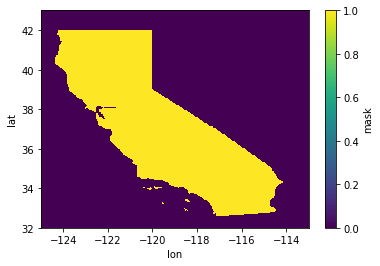

In [21]:
mask.plot()